## Custom ML Vertex AI Pipeline

Owner: Hasan Rafiq @ Google

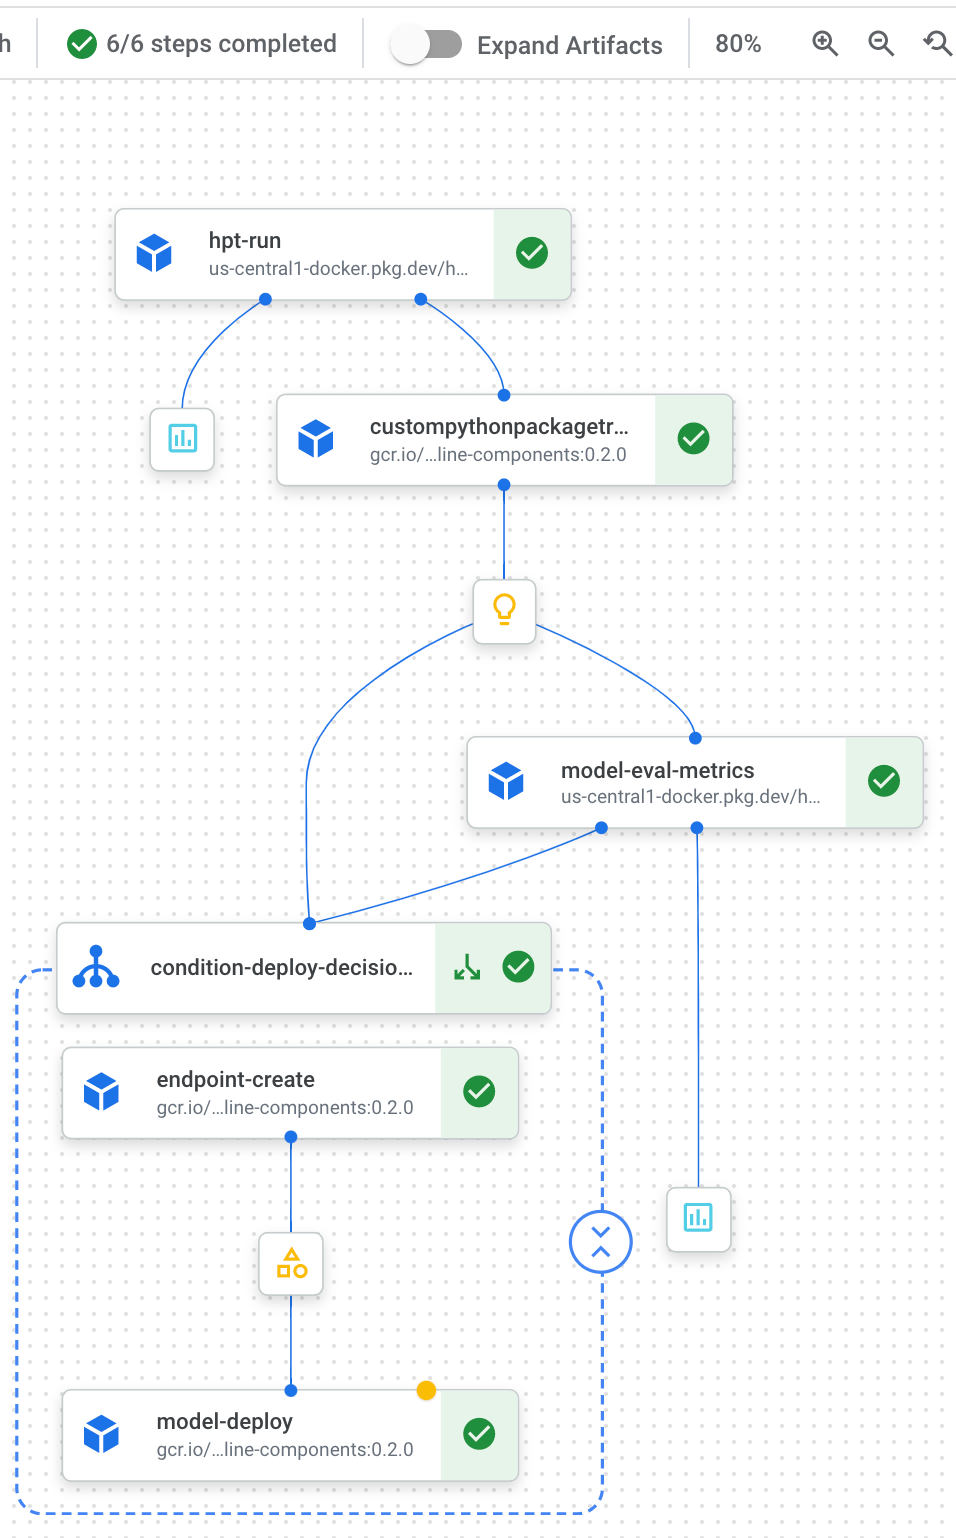

In [2]:
!pip3 install google-cloud-aiplatform==1.7.0 --upgrade
!pip3 install kfp==1.8.9 google-cloud-pipeline-components==0.2.0
!pip3 install cloudml-hypertune

In [3]:
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
!python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

KFP SDK version: 1.8.9
google_cloud_pipeline_components version: 0.2.0


### Step 1 -> Build the trainer package code to be used in custom training operator

In [4]:
%%writefile task.py

# Owner - Hasan Rafiq
# Load the TensorBoard notebook extension

import hypertune
import pandas as pd
import os
from google.cloud import aiplatform
import matplotlib.pyplot as plt
import numpy as np
import argparse
import tensorflow as tf
import tensorflow.keras as keras
  
# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = ['fare', 'trip_start_month', 'trip_start_hour', 'trip_start_day',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude']
LABEL_COLUMN = 'fare'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [[0.0], ['1'], ['1'],['1'],[0.0],[0.0],[0.0],[0.0]]

bins_lat = [41.66367065, 41.85934972, 41.87740612, 41.87925508, 41.88099447,
       41.88498719, 41.88530002, 41.89204214, 41.89207263, 41.89265811,
       41.89830587, 41.89960211, 41.90026569, 41.90741282, 41.92187746,
       41.92926299, 41.9442266 , 41.95402765, 41.97907082, 42.02122359]

bins_lon = [-87.9136246 , -87.76550161, -87.68751552, -87.67161972,
       -87.66341641, -87.65599818, -87.65253448, -87.64629348,
       -87.642649  , -87.63784421, -87.63330804, -87.63274649,
       -87.63186395, -87.62887416, -87.62621491, -87.62519214,
       -87.62099291, -87.62076287, -87.61886836, -87.54093551]

RAW_DATA_FEATURE_SPEC = dict([
        ('fare', tf.io.VarLenFeature(tf.float32)),
        ('trip_start_month', tf.io.VarLenFeature(tf.string)),
        ('trip_start_hour', tf.io.VarLenFeature(tf.string)),
        ('trip_start_day', tf.io.VarLenFeature(tf.string)),
        ('pickup_latitude', tf.io.FixedLenFeature([], tf.float32)),
        ('pickup_longitude', tf.io.FixedLenFeature([], tf.float32)),
        ('dropoff_latitude', tf.io.FixedLenFeature([], tf.float32)),
        ('dropoff_longitude', tf.io.FixedLenFeature([], tf.float32)),
        ])
    
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features( Non-TFT transformation ) -> Just for study purposes
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)

###############################
###Data Input pipeline function

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    # k_pickup_longitude_scaled = tf.keras.Input(name='pickup_longitude_scaled', shape=(1,), dtype=tf.float32, sparse=False) #-> Sparse because VarLenFeature
    # k_pickup_latitude_scaled = tf.keras.Input(name='pickup_latitude_scaled', shape=(1,), dtype=tf.float32, sparse=False) #-> Sparse because VarLenFeature
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string, sparse=False)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string, sparse=False)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string, sparse=False)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32, sparse=False)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance,
                        # 'pickup_longitude_scaled': k_pickup_longitude_scaled,
                        # 'pickup_latitude_scaled' : k_pickup_latitude_scaled
                        }

    return({'K' : keras_dict_input})

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse'),
            keras.metrics.MeanAbsolutePercentageError(name='mape')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary = ['0','1','2','3','4','5','6','7'], mask_token=None, oov_token = '0')(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=8)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    # hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.HashedCrossing(num_bins=24 * 8, output_mode='one_hot')(cross_day_hour)

#     cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
#     hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.HashedCrossing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

#     cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
#     hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.HashedCrossing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
#     embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
#     embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

#     embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
#     embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    # feature_cols['K']['pickup_latitude_scaled'], feature_cols['K']['pickup_longitude_scaled'],
                    feature_cols['K']['distance'], 
                    # embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    # x_numeric = tf.keras.layers.Dense(32, activation='selu', kernel_initializer="lecun_normal")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_input_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_categ = tf.keras.layers.concatenate([
                    cat_month, #cat_cross_day_hour, 
                    cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    # x_categ = tf.keras.layers.Dense(32, activation='selu', kernel_initializer="lecun_normal")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='selu', kernel_initializer="lecun_normal",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
    #Add callbacks
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/")

    #Train and Evaluate
    out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, 
                             tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

    #Best index
    best_epoch = np.argmin(out.history['val_rmse'])

    return (out.history['val_rmse'][best_epoch], out.history['val_mape'][best_epoch])
  
def main(args):
    @tf.function
    def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
        #Params coming in request
        features = {
            'dropoff_latitude': dropoff_latitude,
            'dropoff_longitude': dropoff_longitude,
            'pickup_latitude': pickup_latitude,
            'pickup_longitude': pickup_longitude,
            'trip_start_day': trip_start_day,
            'trip_start_hour': trip_start_hour,
            'trip_start_month': trip_start_month
        }

        #Add TFT transformations
        raw_features = {}
        for key, val in features.items():
          if key not in RAW_DATA_FEATURE_SPEC:
            continue
          if isinstance(RAW_DATA_FEATURE_SPEC[key], tf.io.VarLenFeature):
            raw_features[key] = tf.RaggedTensor.from_tensor(
                tf.expand_dims(val, -1)).to_sparse()
            continue
          raw_features[key] = val
        # tft_new_features = tft_layer(raw_features)

        # pickup_longitude_scaled = tft_new_features['pickup_longitude_scaled'] 
        # pickup_latitude_scaled = tft_new_features['pickup_latitude_scaled']
        distance = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5 ##tft_new_features['distance']

        ##Feature engineering( calculate distance )
        # distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

        #Params in request + New Feature engineering params
        payload = {
            'dropoff_latitude': dropoff_latitude,
            'dropoff_longitude': dropoff_longitude,
            'pickup_latitude': pickup_latitude,
            'pickup_longitude': pickup_longitude,
            'trip_start_day': trip_start_day,
            'trip_start_hour': trip_start_hour,
            'trip_start_month': trip_start_month,
            'distance': distance,
            # 'pickup_longitude_scaled': pickup_longitude_scaled,
            # 'pickup_latitude_scaled': pickup_latitude_scaled,
        }

        ## Predict
        ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
        predictions = m_(payload)
        return predictions

    #####MAIN STARTS
    ##Device Strategy
    device = "cpu"
    if device == "tpu":
      resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
      tf.config.experimental_connect_to_cluster(resolver)
      # This is the TPU initialization code that has to be at the beginning.
      tf.tpu.experimental.initialize_tpu_system(resolver)
      strategy = tf.distribute.experimental.TPUStrategy(resolver)
    else:
      strategy = tf.distribute.MultiWorkerMirroredStrategy()
    
    #Create FC
    create_feature_cols()

    #Create model
    params_default = {
        'lr' : args.lr,
        'beta_1' : 0.99,
        'beta_2' : 0.999,
        'epsilon' : 1e-08,
        'decay' : 0.01,
        'hidden_layers' : args.hidden_layers
    }

    #Create dataset input functions
    train_dataset = make_input_fn(filename = args.train_file,
                        mode = tf.estimator.ModeKeys.TRAIN,
                        batch_size = 128)()

    validation_dataset = make_input_fn(filename = args.eval_file,
                        mode = tf.estimator.ModeKeys.EVAL,
                        batch_size = 512)()

    m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
    # tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

    #Train Model
    rmse, mape = keras_train_and_evaluate(m_, train_dataset, validation_dataset, args.epochs)
    print("Final Val RMSE: ", rmse)
    print("Final Val MAPE: ", mape)
    
    #Log metrics to Vertex MLMD
    aiplatform.init(
        project=args.project,
        location=args.mlmd_region,
        experiment=args.experiment_name
    )
    
    aiplatform.start_run("1")  # Change this to your desired run name
    metrics = {"rmse": rmse, "mape": mape}
    aiplatform.log_metrics(metrics)
    
    #Report metrics for HPT
    hpt = hypertune.HyperTune()
    hpt.report_hyperparameter_tuning_metric(
      hyperparameter_metric_tag='eval_rmse',
      metric_value=rmse,
      global_step=args.epochs)
    
    #Save model
    serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                            trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                            trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                            dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                            dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                            pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                            pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                            )

    ##model Saving
    try:
        model_save_location = os.environ['AIP_MODEL_DIR']
        print("Saving at AIP_MODEL_DIR ", model_save_location) 
    except:
        version = "1"  #{'serving_default': call_output}
        model_save_location = args.model_save_location + version
        print("Saving at custom dir ", model_save_location)        
        
    print("Saving model...")
    
    tf.saved_model.save(
        m_,
        model_save_location,
        signatures=serving
    )

if __name__ == '__main__':
    ##Parse Arguments
    parser = argparse.ArgumentParser()
    parser.add_argument(
      '--train_file', required=True, type=str, help='Training file')
    parser.add_argument(
      '--eval_file', required=True, type=str, help='Eval file')
    parser.add_argument(
      '--model_save_location', required=True, type=str, help='Model save location')
    parser.add_argument(
      '--epochs', required=False, type=int, help='Epochs', default=100)
    parser.add_argument(
      '--lr', required=False, type=float, help='Learning Rate', default=0.001)
    parser.add_argument(
      '--hidden_layers', required=False, type=int, help='Hidden layers', default=1)
    parser.add_argument(
      '--experiment_name', required=True, type=str, help='Experiment ID')
    parser.add_argument(
      '--mlmd_region', required=True, type=str, help='Region')
    parser.add_argument(
      '--project', required=True, type=str, help='Project')
    args = parser.parse_args()
    
    #Run Main Trainer
    main(args)

Overwriting task.py


In [5]:
##Test the job
!python task.py \
--train_file='gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/train.csv' \
--eval_file='gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/eval.csv' \
--model_save_location='gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/model/' \
--experiment_name='custom-model-test' \
--mlmd_region='us-central1' \
--project='hasanrafiq-test-331814' \
--epochs=3 \
--lr=0.001 \
--hidden_layers=2

2022-01-24 18:50:55.307117: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 trip_start_month (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None, 1)]    

In [6]:
%%writefile setup.py

from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = ['absl-py','pandas','google-cloud-aiplatform',
                     'google-cloud','google-cloud-storage','google-cloud-firestore','google-api-python-client', 'google-auth']

setup(
    name='trainer',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    packages=find_packages(),
    include_package_data=True,
    description='Hasan - Vertex AI Taxi Trainer Job'
)

Overwriting setup.py


In [7]:
%%writefile __init__.py
  

Overwriting __init__.py


In [8]:
 # Create ML train package
!rm -rf dist*
!rm -rf trainer*
!rm -rf trainer/
!rm -rf dist/

!mkdir trainer/
!cp task.py trainer/
!cp __init__.py trainer/
!python setup.py sdist

# Copy trainer.gz to GCS training path
!gsutil cp dist/trainer-0.1.tar.gz gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/ml_scripts/

running sdist
running egg_info
creating trainer.egg-info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing requirements to trainer.egg-info/requires.txt
writing top-level names to trainer.egg-info/top_level.txt
writing manifest file 'trainer.egg-info/SOURCES.txt'
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'
running check


creating trainer-0.1
creating trainer-0.1/components
creating trainer-0.1/pipelines
creating trainer-0.1/trainer
creating trainer-0.1/trainer.egg-info
copying files to trainer-0.1...
copying README.md -> trainer-0.1
copying setup.py -> trainer-0.1
copying components/__init__.py -> trainer-0.1/components
copying components/hpt.py -> trainer-0.1/components
copying components/regression_eval_model.py -> trainer-0.1/components
copying pipelines/__init__.py -> trainer-0.1/pipelines
copying pipelines/train_pipeline.py -> trainer-0.1/pipelines
copying train

### Step 2 -> Now build pipeline

In [9]:
%%writefile pipelines/train_pipeline.py
import os

import kfp
import time
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import component, pipeline, Artifact, ClassificationMetrics, Input, Output, Model, Metrics

from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from typing import NamedTuple, Dict

from google.cloud import aiplatform

#Main pipeline class
class pipeline_controller():
    def __init__(self, template_path, display_name, pipeline_root, project_id, region):
        self.template_path = template_path
        self.display_name = display_name
        self.pipeline_root = pipeline_root
        self.project_id = project_id
        self.region = region
    
    def _build_compile_pipeline(self):
        """Method to build and compile pipeline"""
        self.pipeline = self._get_pipeline()
        compiler.Compiler().compile(
            pipeline_func=self.pipeline, package_path=self.template_path
        )
        
    def _submit_job(self):
        """Method to Submit ML Pipeline job"""
        #Next, define the job:
        ml_pipeline_job = aiplatform.PipelineJob(
            display_name=self.display_name,
            template_path=self.template_path,
            pipeline_root=self.pipeline_root,
            parameter_values={"project": self.project_id, "display_name": self.display_name},
            enable_caching=False
        )

        #And finally, run the job:
        ml_pipeline_job.submit()
    
    def _get_pipeline(self):
        """Main method to Create pipeline"""
        @pipeline(name=self.display_name,
                          pipeline_root=self.pipeline_root)
        def pipeline_fn(
            display_name: str = self.display_name,
            project: str = self.project_id,
            gcp_region: str = self.region,
            api_endpoint: str = "us-central1-aiplatform.googleapis.com",
            thresholds_dict_str: str = '{"rmse_threshold": 4.8}',
        ):
            
            #Load all reusable custom components
            eval_op = kfp.components.load_component('component_specs/regression_eval_model.yaml')
            hpt_op = kfp.components.load_component('component_specs/hpt.yaml')

            #STEP: For non Auto-ML call
            hpt_args = ['--train_file', 'gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/train.csv',
                         '--eval_file', 'gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/eval.csv',
                         '--model_save_location', 'gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/model/',
                         '--hidden_layers','2',
                         '--experiment_name', "{{$.inputs.parameters['display_name']}}-hpt-job" ,  #This is also a way to pass a parameter as input
                         '--mlmd_region', "{{$.inputs.parameters['pipelineparam--gcp_region']}}" ,
                         '--project', "{{$.inputs.parameters['project']}}"
                        ]
            
            #HPT
            hpt_task = hpt_op(
                project=project,
                display_name=display_name,
                service_account='318948681665-compute@developer.gserviceaccount.com',  ##Needed for Vertex MLMD access
                executor_image_uri='us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-7:latest',
                package_uri="gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/ml_scripts/trainer-0.1.tar.gz",
                python_module="trainer.task",
                hpt_args=hpt_args,
                metric_id="eval_rmse",
                goal=aiplatform.gapic.StudySpec.MetricSpec.GoalType.MINIMIZE,
                location=gcp_region,
                api_endpoint=str(f"{gcp_region}-aiplatform.googleapis.com")
            )

            #Training
            training_args = ['--train_file', 'gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/train.csv',
                             '--eval_file', 'gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/eval.csv',
                             '--model_save_location', 'gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/model/',  ##Model will save at AIP_MODEL_DIR
                             '--epochs', '10',
                             '--hidden_layers', str(hpt_task.outputs["hidden_layers"]),
                             '--lr', str(hpt_task.outputs["lr"]),
                             '--experiment_name', str(f"{display_name}-train-job"),
                             '--mlmd_region', str(gcp_region) ,
                             '--project', str(project) ,
                            ]
            
            training_op = gcc_aip.CustomPythonPackageTrainingJobRunOp(
                            project=project,
                            display_name=display_name,
                            service_account='318948681665-compute@developer.gserviceaccount.com',  ##Needed for Vertex MLMD access
                            python_package_gcs_uri="gs://gcs-hasanrafiq-test-331814/ml_data/taxi_dataset/ml_scripts/trainer-0.1.tar.gz",
                            staging_bucket='gs://cloud-ai-platform-35f2698c-5046-4c70-857e-14cb44e3950a/ml_staging',
                            python_module_name="trainer.task",
                            container_uri='us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-7:latest',
                            model_serving_container_image_uri='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest',
                            model_display_name='vertex-customml-taxi',
                            replica_count=1,
                            location=gcp_region,
                            machine_type="n1-standard-4",
                            args=training_args
                          )

            #Model Evaluation
            model_eval_task = eval_op(
                                    project,
                                    gcp_region,
                                    str(f"{display_name}-train-job"),
                                    thresholds_dict_str,
                                    training_op.outputs["model"])
                
            with dsl.Condition(
                model_eval_task.outputs["dep_decision"] == "true",
                name="deploy_decision",
            ):

                endpoint_op = gcc_aip.EndpointCreateOp(
                    project=project,
                    location=gcp_region,
                    display_name="vertex-customml-taxi",
                )

                gcc_aip.ModelDeployOp(
                    model=training_op.outputs["model"],
                    endpoint=endpoint_op.outputs["endpoint"],
                    dedicated_resources_min_replica_count=1,
                    dedicated_resources_max_replica_count=1,
                    dedicated_resources_machine_type="n1-standard-4",
                )
            
        return pipeline_fn

Overwriting pipelines/train_pipeline.py


#### Build and Upload image to GAR

In [10]:
%%bash
docker build -t us-central1-docker.pkg.dev/hasanrafiq-test-331814/vertex-customml-pipeline-test/latest:latest -f Dockerfile .
docker push us-central1-docker.pkg.dev/hasanrafiq-test-331814/vertex-customml-pipeline-test/latest:latest

Sending build context to Docker daemon  2.129MB
Step 1/4 : FROM python:3.7-slim AS builder
 ---> d3c9ad326043
Step 2/4 : COPY requirements.txt .
 ---> Using cache
 ---> 71ab63d04aea
Step 3/4 : RUN pip install -r requirements.txt
 ---> Using cache
 ---> f441fe232539
Step 4/4 : COPY . .
 ---> 02049d964be3
Successfully built 02049d964be3
Successfully tagged us-central1-docker.pkg.dev/hasanrafiq-test-331814/vertex-customml-pipeline-test/latest:latest
The push refers to repository [us-central1-docker.pkg.dev/hasanrafiq-test-331814/vertex-customml-pipeline-test/latest]
b6fd794eea2e: Preparing
71147fe53e89: Preparing
c5c70a818500: Preparing
25ad0307b4c1: Preparing
874b45955cb1: Preparing
85c923303735: Preparing
d0fa20bfdce7: Preparing
2edcec3590a4: Preparing
85c923303735: Waiting
d0fa20bfdce7: Waiting
2edcec3590a4: Waiting
25ad0307b4c1: Layer already exists
c5c70a818500: Layer already exists
85c923303735: Layer already exists
874b45955cb1: Layer already exists
71147fe53e89: Layer already exis

#### Directly test running of pipeline from here

In [11]:
#Initialize pipeline object
from pipelines.train_pipeline import pipeline_controller
import time

PROJECT_ID = "hasanrafiq-test-331814"
REGION="us-central1"

BUCKET_NAME=f"gs://gcs-{PROJECT_ID}"
BUCKET_NAME

PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

DISPLAY_NAME = 'hasantest-vertex-customml-pipeline{}'.format(str(int(time.time())))
DISPLAY_NAME

pipe = pipeline_controller(template_path="pipeline.json",
                           display_name="customml-taxi-training", 
                           pipeline_root=PIPELINE_ROOT,
                           project_id=PROJECT_ID,
                           region=REGION)

#Build and Compile pipeline
pipe._build_compile_pipeline()

# #Submit Job
pipe._submit_job()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/318948681665/locations/us-central1/pipelineJobs/customml-taxi-training-20220124185124
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/318948681665/locations/us-central1/pipelineJobs/customml-taxi-training-20220124185124')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/customml-taxi-training-20220124185124?project=318948681665


In [12]:
# from typing import NamedTuple
# import inspect

# def test() -> NamedTuple("Outputs", [("lr", float), ("hidden_layers", float)]):
#     return (1, 2)

# inspect.signature(test).return_annotation._fields

In [13]:
# len(test())